<a href="https://www.kaggle.com/code/omarmostafataha/sales-prediction-with-accuracy-97-2-using-xgboost?scriptVersionId=141012951" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split , GridSearchCV 
from sklearn.preprocessing import StandardScaler ,PolynomialFeatures 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression , Ridge 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor
from category_encoders import BinaryEncoder
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/walmart-dataset/Walmart.csv


# Data Exploration

In [2]:
df = pd.read_csv('/kaggle/input/walmart-dataset/Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
df.duplicated().sum()

0

* the data has no duplicates or missing values.

In [6]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


* weekly_sales column has outliers<br>
* Temperature column has some negative values<br>
* CPI column has outliers

# Feature Engineering

In [7]:
def get_season(month):
    '''this function is to get season according to month column'''
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

* Now let's create new features Month, Year and Season from Date column.


In [8]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Season'] = df['Month'].apply(get_season)

In [9]:
df.sample(3)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Season
6307,45,2010-05-21,747888.25,0,62.62,2.958,181.853849,8.899,5,2010,Spring
2399,17,2012-03-23,851762.28,0,40.69,3.671,130.896645,6.403,3,2012,Spring
902,7,2010-12-10,599730.07,0,24.24,2.728,190.974107,9.137,12,2010,Winter


# Exploratory Data Analysis

<h2>1. Univariate Analysis

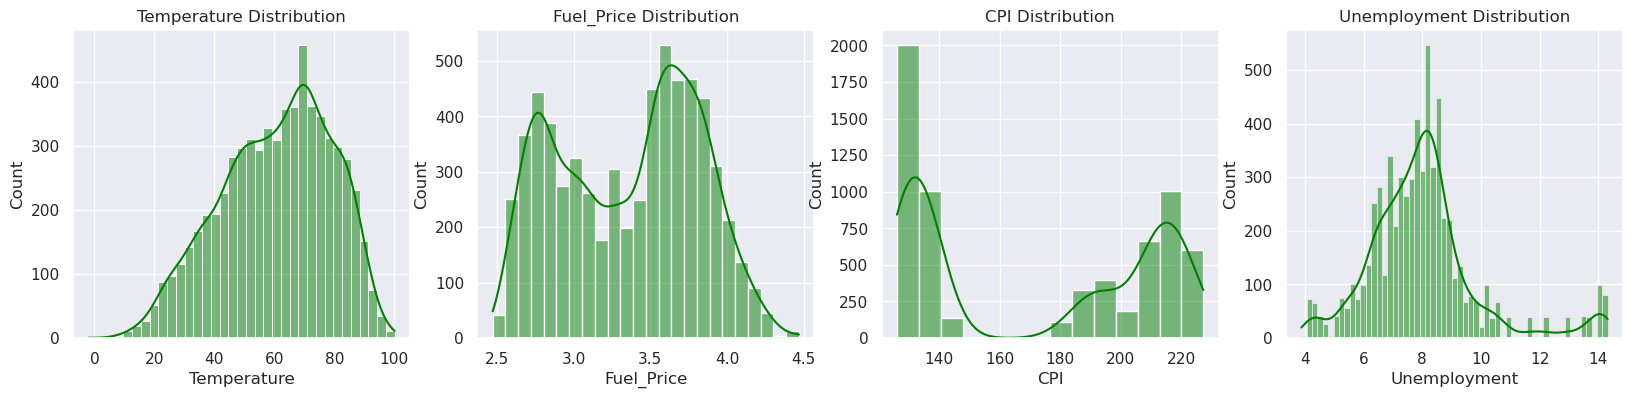

In [10]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.histplot(df,
                 x=col,
                 ax=ax[i],
                 kde=True,
                 color = 'green'
                )
    ax[i].set_title(f'{col} Distribution')
fig.show()    

* CPI and Fuel_Price have bimodal distribution.
* Temperature and Unemployment have normal distribution.

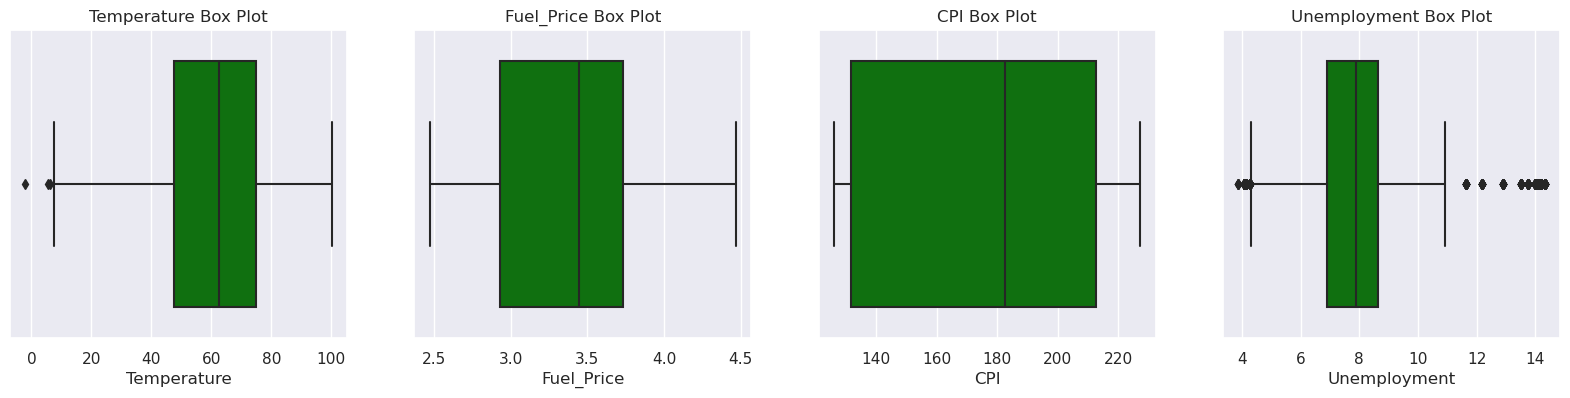

In [11]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.boxplot(df,
                 x=col,
                 ax=ax[i],
                 color = 'green'
                )
    ax[i].set_title(f'{col} Box Plot')
fig.show()    

* Unemployment column has outliers that need to be handled.

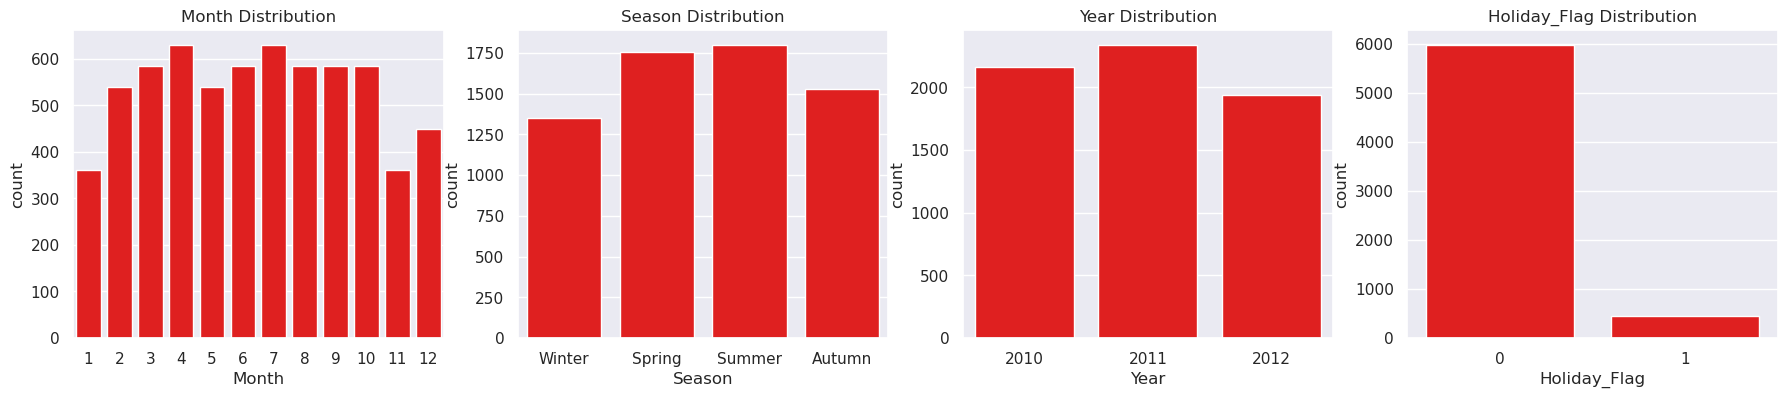

In [12]:
fig , ax = plt.subplots(1,4,figsize=(22,4))
cols = ['Month','Season','Year','Holiday_Flag']
for i,col in enumerate(cols):
    sns.countplot(df,
                 x=col,
                 ax=ax[i],
                 color = 'Red'
                )
    ax[i].set_title(f'{col} Distribution')
fig.show()    

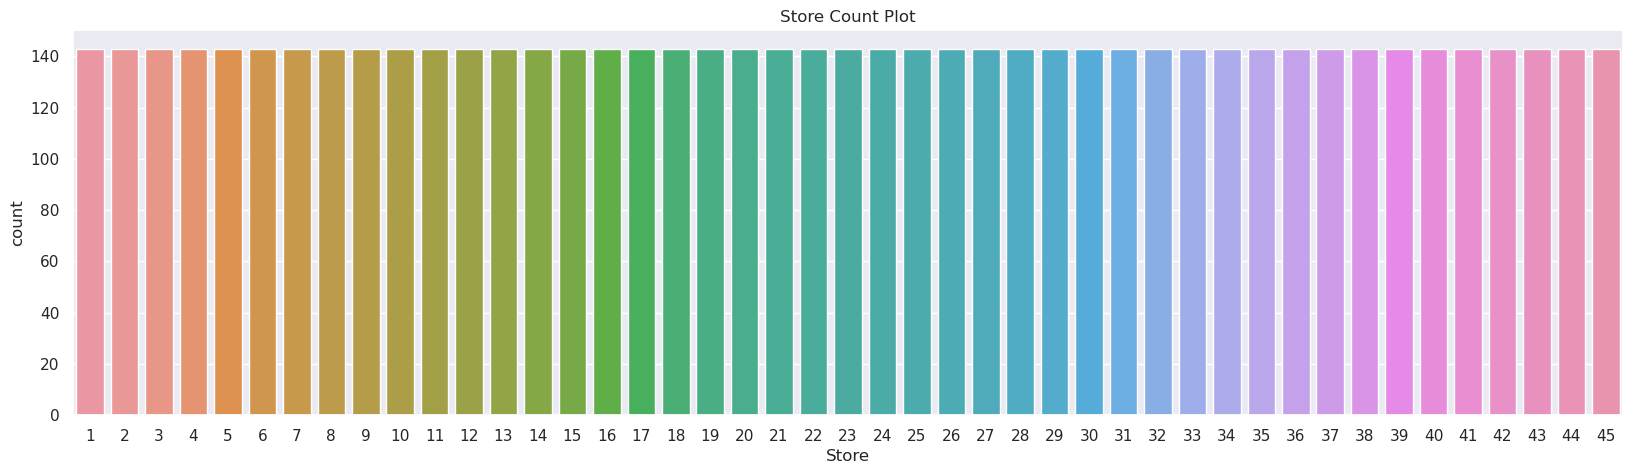

In [13]:
plt.figure(figsize=(20,5))
sns.countplot(df,x='Store');
plt.title('Store Count Plot');

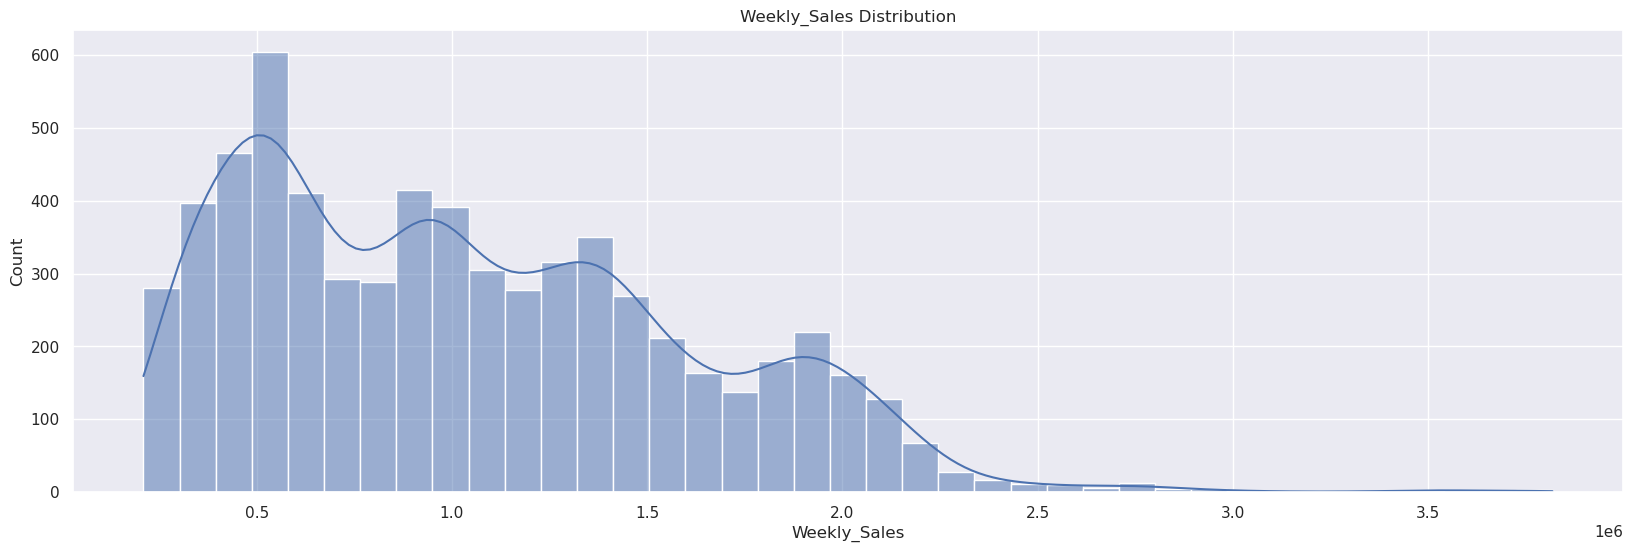

In [14]:
plt.figure(figsize=(20,6))
sns.histplot(x=df['Weekly_Sales'],kde=True);
plt.title('Weekly_Sales Distribution');

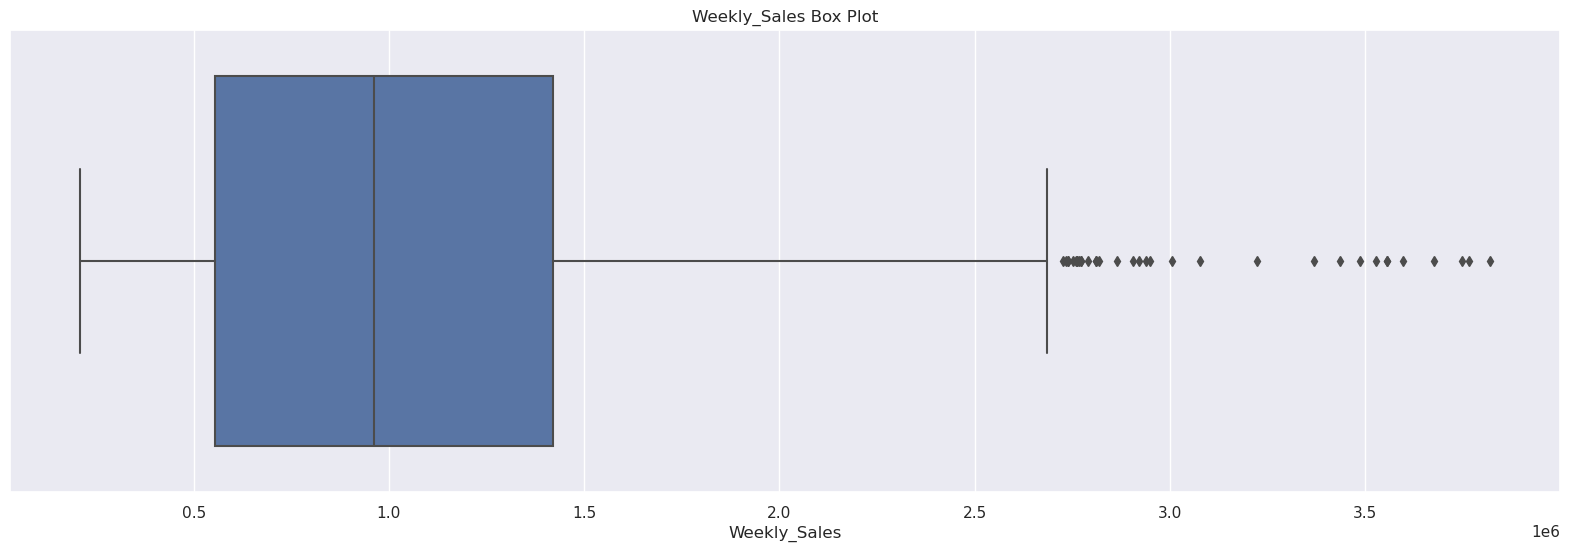

In [15]:
plt.figure(figsize=(20,6))
sns.boxplot(x=df['Weekly_Sales']);
plt.title('Weekly_Sales Box Plot');

* Weekly_Sales distribution is right skewed as it has some outliers.

<h2>2. Bivariate Analysis

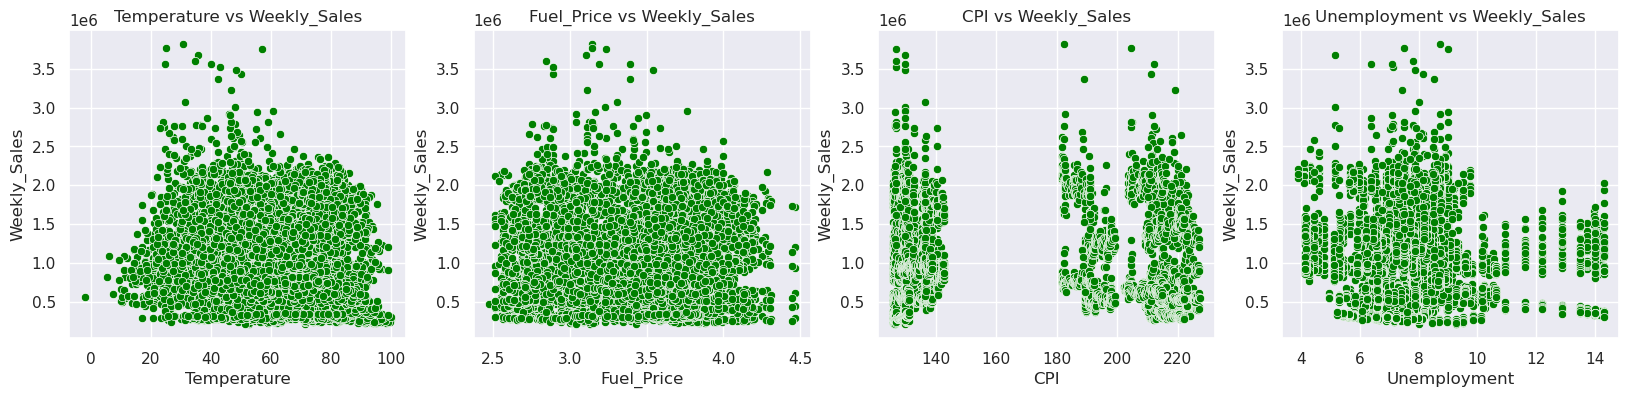

In [16]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.scatterplot(df,
                 y='Weekly_Sales',x=col,
                 ax=ax[i],
                 color = 'green'
                )
    ax[i].set_title(f'{col} vs Weekly_Sales')
fig.show()    

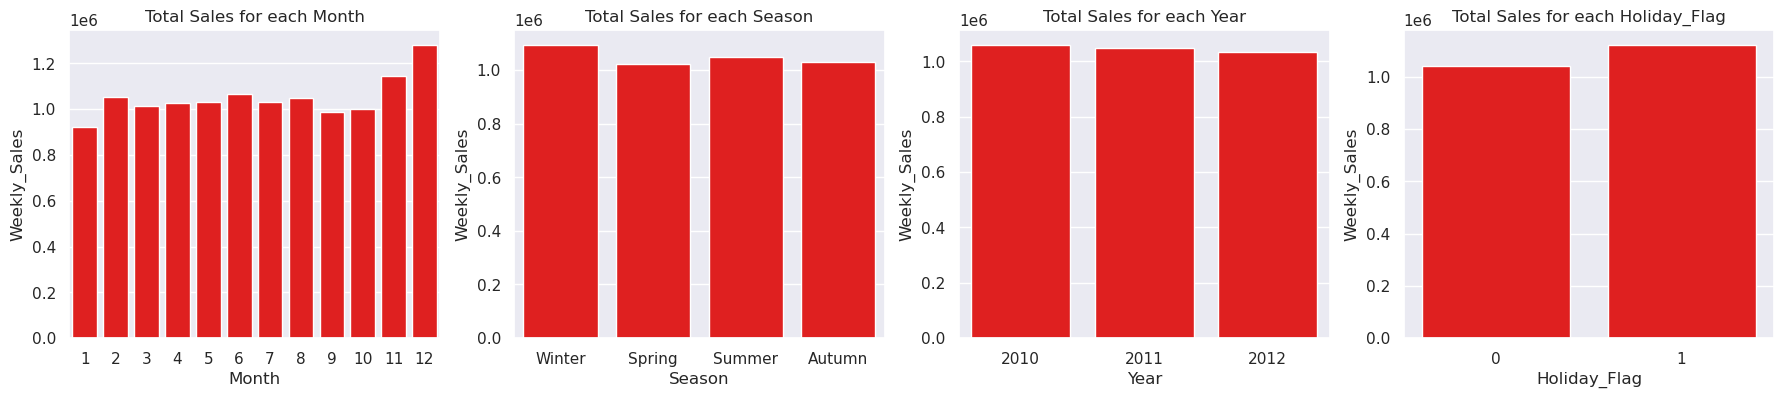

In [17]:
fig , ax = plt.subplots(1,4,figsize=(22,4))
cols = ['Month','Season','Year','Holiday_Flag']
for i,col in enumerate(cols):
    sns.barplot(df,
                 x=col,y='Weekly_Sales',
                 ax=ax[i],
                 errorbar=None,
                 color='Red'
                )
    ax[i].set_title(f'Total Sales for each {col}')
fig.show()    


* Sales tend to be higher in winter and holidays.
* Sales are higher in Months 11 ,12.

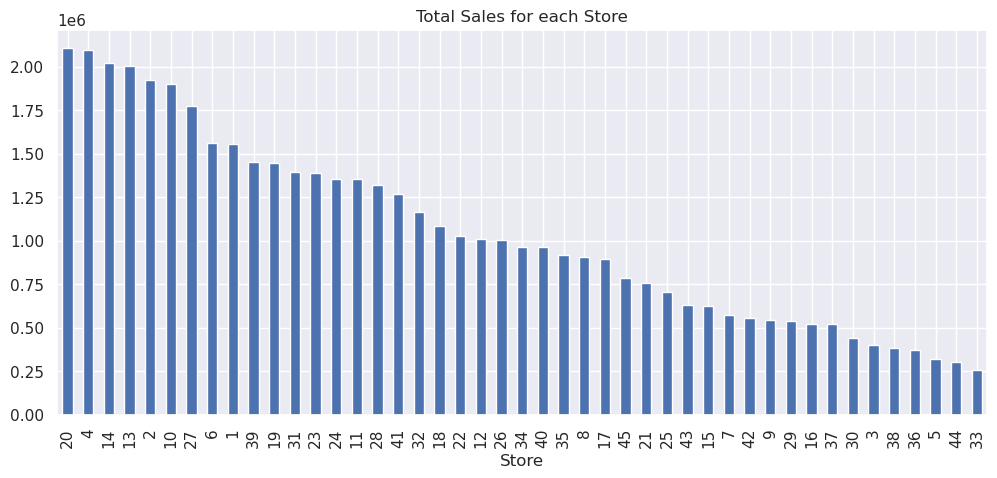

In [18]:
plt.figure(figsize=(12,5))
df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).plot(kind='bar');
plt.title('Total Sales for each Store');

* Stores 20 ,4 ,14 ,13 ,2 achieved the highest sales with sales over 2M while stores like 33,44,5 achieve the lowest sales with sales around 0.25M.

**This is the most important step to achieve the highest accuracy as we can't treat Store as numerical feature so we should transform it to categorical one first before modeling.**

In [19]:
df['Store'] = df['Store'].astype('object')

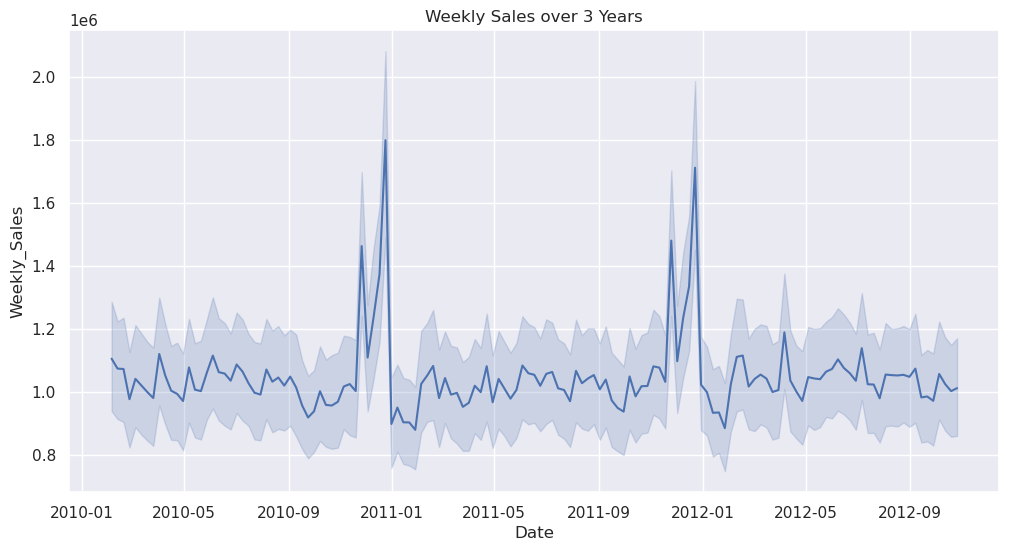

In [20]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df["Date"],y=df['Weekly_Sales']);
plt.title('Weekly Sales over 3 Years');

* as we mentioned before ,Sales are higher in Months 11 ,12.

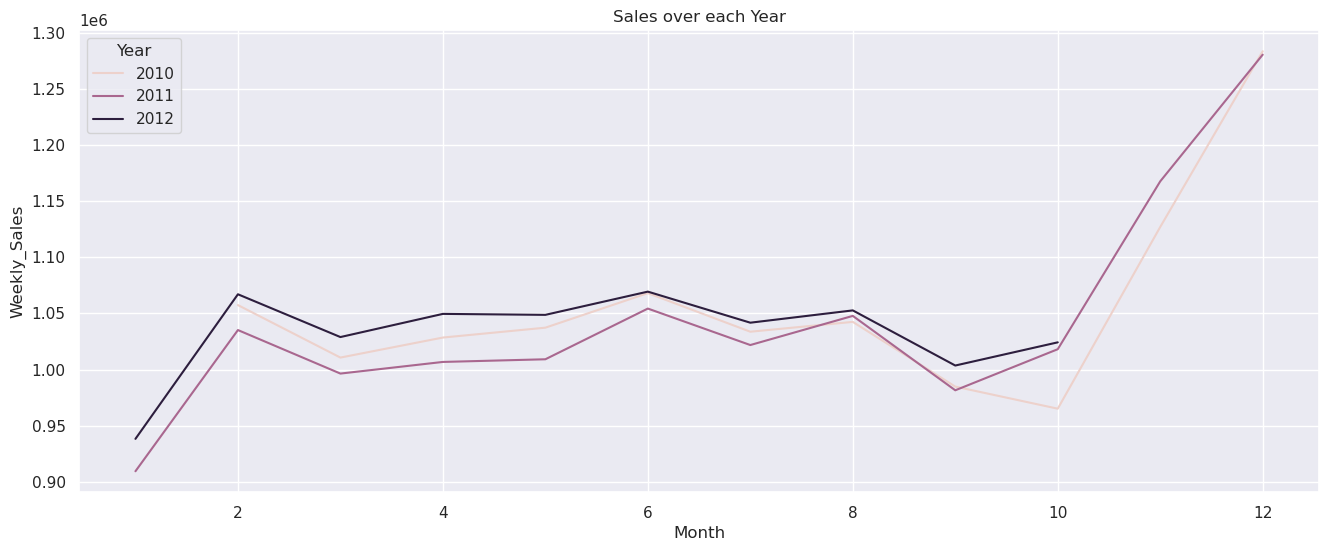

In [21]:
plt.figure(figsize=(16,6))
sns.lineplot(x=df["Month"],y=df['Weekly_Sales'],hue=df['Year'],ci=None);
plt.title('Sales over each Year');

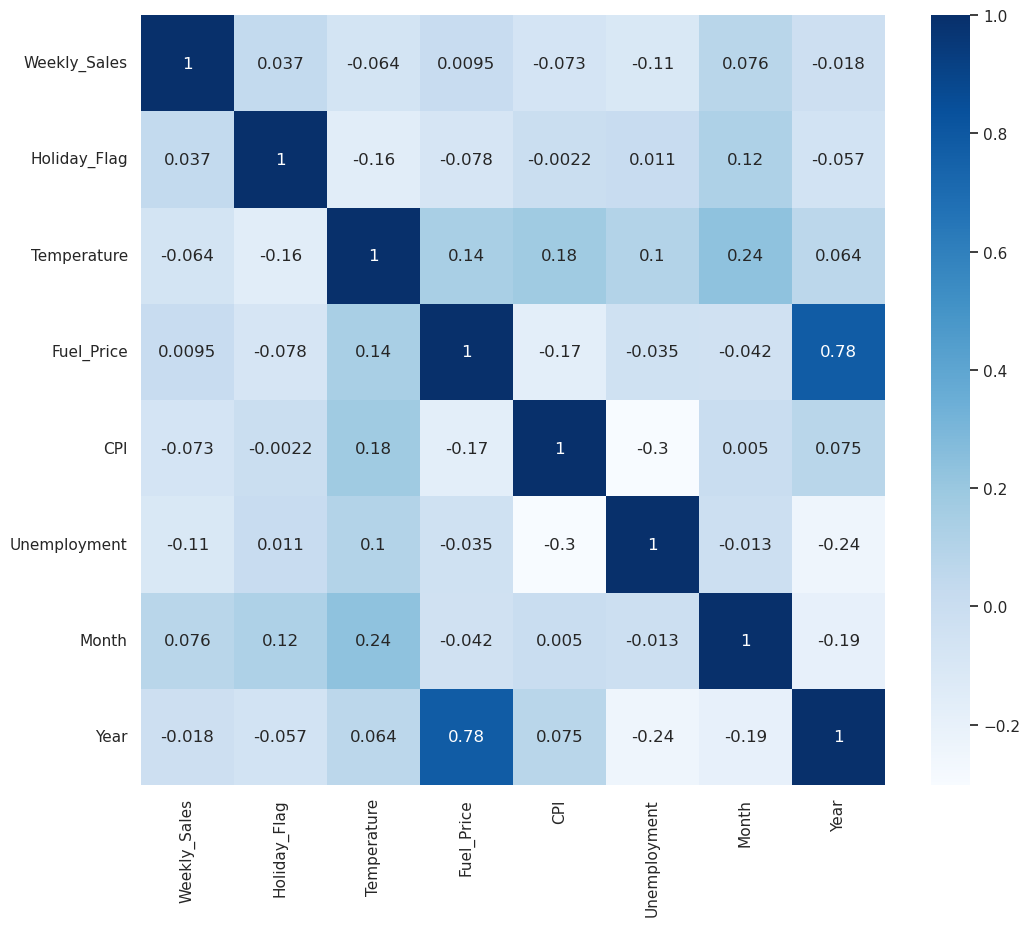

In [22]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True),cmap='Blues',annot=True);

<h2> Removing Outliers

In [23]:
num_features = ['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']
for feature in num_features:
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    df = df[(df[feature] >= lower) & (df[feature] <= upper)]

# Model Building

In [24]:
def tune_and_evaluate(model,param_grid):
    
    '''This function recieves a model then tune it using GridSearch 
    then print the best parameters and return the best estimator'''
    
    # tunning the model
    grid_search = GridSearchCV(estimator= model,param_grid= param_grid,cv=5,scoring='r2')
    grid_search.fit(X_train,y_train)
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_
    print("Best parameters are: ",best_params)
    print('Mean cross-validated score of the best_estimator is: ',best_score)
    print('-------------------------------------------------------------------')
    
    # best estimator evaluation
    print("Training set Accuracy:",round(best_estimator.score(X_train,y_train),3)*100)
    print("Test set Accuracy:",round(best_estimator.score(X_test,y_test),3)*100)
    
    return best_estimator

<h2> Data Splitting and Preprocessing

In [25]:
num_vars = ['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']

# scaling numerical variables
sc = StandardScaler()
df[num_vars] = sc.fit_transform(df[num_vars])

# encoding categorical features
encoder = BinaryEncoder(cols=['Store','Season'])
df = encoder.fit_transform(df)

In [26]:
features = df.columns.drop(['Weekly_Sales','Date','Year'])
target = 'Weekly_Sales'

X = df[features]
y = df[target]

X_train , X_test , y_train , y_test = train_test_split(X,y,random_state=42 ,  test_size=0.2)

# 1. Linear Regression

In [27]:
# building the model
lin_reg = make_pipeline(
        PolynomialFeatures(degree=2),
        LinearRegression()
)

# hyperparameter tunning
param_grid = {'polynomialfeatures__degree':[2,3,4]}
lin_reg = tune_and_evaluate(lin_reg,param_grid)

Best parameters are:  {'polynomialfeatures__degree': 3}
Mean cross-validated score of the best_estimator is:  0.9632910021485515
-------------------------------------------------------------------
Training set Accuracy: 97.7
Test set Accuracy: 95.89999999999999


# 2. Ridge

In [28]:
# building the model
ridge = make_pipeline(
        PolynomialFeatures(degree=2),
        Ridge()
)

# hyperparameter tunning
param_grid = {
    'polynomialfeatures__degree':[2,3,4],
    'ridge__alpha':[1e-2,1e-3,1e-4]
}
ridge = tune_and_evaluate(ridge,param_grid)

Best parameters are:  {'polynomialfeatures__degree': 3, 'ridge__alpha': 0.001}
Mean cross-validated score of the best_estimator is:  0.9632890708372213
-------------------------------------------------------------------
Training set Accuracy: 97.7
Test set Accuracy: 95.89999999999999


# 3. KNNRegressor

In [29]:
# building the model
knn = KNeighborsRegressor()

# hyperparameter tunning
param_grid = {
    'n_neighbors': np.arange(1, 10),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = tune_and_evaluate(knn,param_grid)

Best parameters are:  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Mean cross-validated score of the best_estimator is:  0.9058335454944505
-------------------------------------------------------------------
Training set Accuracy: 100.0
Test set Accuracy: 91.9


# 4. Decision Tree

In [30]:
# building the model
dec_tree = DecisionTreeRegressor()

# hyperparameter tunning
param_grid = {'max_depth': np.arange(2,13)}
dec_tree = tune_and_evaluate(dec_tree,param_grid)

Best parameters are:  {'max_depth': 9}
Mean cross-validated score of the best_estimator is:  0.936773372336418
-------------------------------------------------------------------
Training set Accuracy: 97.3
Test set Accuracy: 93.30000000000001


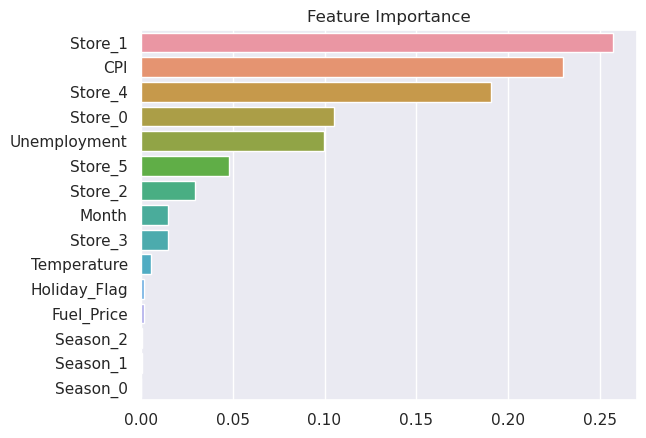

In [31]:
feat_imp = pd.Series(dec_tree.feature_importances_, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title('Feature Importance');

# 5. Random Forest

In [32]:
# building the model
random_forest = RandomForestRegressor(n_jobs=-1)

# hyperparameter tunning
param_grid = {
    'max_depth': np.arange(2,15),
    'n_estimators': np.arange(25,101,25)
}
random_forest = tune_and_evaluate(random_forest,param_grid)

Best parameters are:  {'max_depth': 13, 'n_estimators': 75}
Mean cross-validated score of the best_estimator is:  0.95462583100551
-------------------------------------------------------------------
Training set Accuracy: 99.1
Test set Accuracy: 95.6


# 6. XGBoost

In [33]:
# building the model
xgb = XGBRegressor(n_jobs=-1)

# hyperparameter tunning
param_grid = {
    'max_depth': np.arange(2,10),
    'n_estimators': np.arange(20,201,20)
}
xgb = tune_and_evaluate(xgb,param_grid)

Best parameters are:  {'max_depth': 7, 'n_estimators': 160}
Mean cross-validated score of the best_estimator is:  0.9677135525818354
-------------------------------------------------------------------
Training set Accuracy: 99.9
Test set Accuracy: 97.2


# Conclusion

* Sales tend to be higher in winter.
* There is a high variance in sales from one store to another.
* The best performing model is XGBoost with an accuracy of 96% on the training set and 97.2% on the test set.

In [34]:
# saving the model
with open('xgb.pkl','wb') as file:
    pickle.dump(xgb,file)